In [ ]:
! wget http://images.cocodataset.org/zips/train2014.zip
! wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
! sudo apt-get install unzip
! unzip train2014.zip -d coco
! unzip annotations_trainval2014.zip -d coco

# Image Captioning

In [ ]:
import pandas as pd
import os
import json


class DatasetLoader:

    def __init__(self, folder_name: str = "coco"):
        self.data = self.load_data(folder_name)

    def load_data(self, folder_name: str = "coco"):
        print("Loading data..")
        # Set the data folder
        data_folder = os.path.join(folder_name)

        # Create the directory if it doesn't exist
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)

        # Path to the captions JSON file
        filename = os.path.join(data_folder, "annotations", "captions_train2014.json")

        # Read and parse the JSON file
        with open(filename, "r") as json_file:
            data = json.load(json_file)

        print("Data loaded succesfully!")

        return data

    def get_data_dict(self):
        return self.data

    def get_df_annotations(self):
        return pd.DataFrame(self.data["annotations"])

    def get_df_images(self):
        return pd.DataFrame(self.data["images"])


## Setup

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

## Download the dataset

We will be using the Flickr8K dataset for this tutorial. This dataset comprises over
8,000 images, that are each paired with five different captions.

In [ ]:
# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 256
EPOCHS = 15
AUTOTUNE = tf.data.AUTOTUNE

## Preparing the dataset

In [ ]:
import json
import os
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input
# from fdl_project.classes.dataset_loader import DatasetLoader

# Load the dataset
dataset = DatasetLoader().load_data(folder_name=os.path.join(os.getcwd(), "coco"))

Loading data..
Data loaded succesfully!
Loading data..
Data loaded succesfully!


In [ ]:
def load_captions_data(dataset):
    text_annotations = []

    # Create a mapping from image_id to file_name
    image_id_to_file_name = {image["id"]: image["file_name"] for image in dataset["images"]}

    # Create a mapping from image_id to captions
    image_id_to_captions = {}
    for annotation in dataset["annotations"]:
        image_id = annotation["image_id"]
        caption = "<start> " + annotation["caption"] + " <end>"

        if image_id not in image_id_to_captions:
            image_id_to_captions[image_id] = []

        image_id_to_captions[image_id].append(caption)
        text_annotations.append(caption)

    # Create a combined dictionary with image file names and their corresponding captions
    file_name_to_captions = {
        image_id_to_file_name[image_id]: captions
        for image_id, captions in image_id_to_captions.items()
    }

    return file_name_to_captions, text_annotations


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

# Load the dataset
captions_mapping, text_data = load_captions_data(dataset)

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  66226
Number of validation samples:  16557


In [ ]:
captions_mapping

## Vectorizing the text data

We'll use the `TextVectorization` layer to vectorize the text data,
that is to say, to turn the
original strings into integer sequences where each integer represents the index of
a word in a vocabulary. We will use a custom string standardization scheme
(strip punctuation characters except `<` and `>`) and the default
splitting scheme (split on whitespace).

In [ ]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


## Building a `tf.data.Dataset` pipeline for training

We will generate pairs of images and corresponding captions using a `tf.data.Dataset` object.
The pipeline consists of two steps:

1. Read the image from the disk
2. Tokenize all the five captions corresponding to the image

In [ ]:
# append coco/train2014/ to all the keys of the dictionary

train_data = {
    os.path.join("coco/train2014/", key): value for key, value in train_data.items()
}

valid_data = {
    os.path.join("coco/train2014/", key): value for key, value in valid_data.items()
}

In [ ]:
train_data["coco/train2014/COCO_train2014_000000254362.jpg"]

['<start> Three picture frames of ducks swimming in water. <end>',
 '<start> Multiple shots of birds swimming on top of the water. <end>',
 '<start> A group of ducks on a calm body of water. <end>',
 '<start> A set of three photos showing a group of ducks moving across water. <end>',
 '<start> Three film clips of a pond of ducks.  <end>',
 '<start> Three panels of ducks swimming on a wide pond. <end>']

In [ ]:
# check in train_data if there are more than 5 values
# remove the 6th value and keep the first 5 values

for key, value in train_data.items():
    if len(value) > 5:
        # print(key, len(value))
        train_data[key] = value[:5]

for key, value in valid_data.items():
    if len(value) > 5:
        # print(key, len(value))
        valid_data[key] = value[:5]

In [ ]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    print("PROCESS_INPUT: LEN DATASET", len(dataset))
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, tf.ragged.constant((captions))))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

PROCESS_INPUT: LEN DATASET 4
PROCESS_INPUT: LEN DATASET 4


## Building the model

Our image captioning architecture consists of three models:

1. A CNN: used to extract the image features
2. A TransformerEncoder: The extracted image features are then passed to a Transformer
                    based encoder that generates a new representation of the inputs
3. A TransformerDecoder: This model takes the encoder output and the text data
                    (sequences) as inputs and tries to learn to generate the caption.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Assume IMAGE_SIZE is defined elsewhere, e.g., IMAGE_SIZE = (224, 224)
# Assume EMBED_DIM is defined, e.g., EMBED_DIM = 256


def get_cnn_model(input_shape=(*IMAGE_SIZE, 3)):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="leaky_relu", padding="same")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="leaky_relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation="leaky_relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, 3, activation="leaky_relu", padding="same")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(EMBED_DIM, activation="leaky_relu")(x)
    return keras.Model(inputs, x)


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, training, mask=None):
        inputs = tf.expand_dims(inputs, axis=1)  # Add sequence dimension
        attention_output = self.attention(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

## Model training

In [ ]:
try:
    from google.colab import drive
    import datetime
    drive.mount('/content/gdrive')

    # Create a directory in Google Drive to store models
    !mkdir /content/gdrive/My\ Drive/Colab_Models
    loss_model_path = "/content/gdrive/My Drive/Colab_Models/loss_leaky_relu_model_from_scratch_transformer_small_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + ".txt"
    checkpoint_path = "/content/gdrive/My Drive/Colab_Models/cp_leaky_relu_model_from_scratch_transformer_small_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    open(loss_model_path, 'w').close()
except:
    loss_model_path = "loss_model_from_scratch_LSTM_CNN.txt"
    checkpoint_path = "cp_model_from_scratch_LSTM_CNN.weights.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    open(loss_model_path, 'w').close()

Mounted at /content/gdrive
mkdir: cannot create directory ‘/content/gdrive/My Drive/Colab_Models’: File exists


In [ ]:

# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='none',
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import _pickle as pickle

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {'loss':[],'val_loss':[]}

    def on_batch_end(self, batch, logs={}):
        self.history['loss'].append(logs.get('loss'))
        with open(loss_model_path, "r+b") as myfile:
            myfile.write(pickle.dumps(self.history))

    def on_epoch_end(self, epoch, logs={}):
        self.history['val_loss'].append(logs.get('val_loss'))

history = LossHistory()

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping, cp_callback, history],
)

Epoch 1/15
259/259 [==============================] - ETA: 0s - loss: 22.3167 - acc: 0.2281
Epoch 1: saving model to /content/gdrive/My Drive/Colab_Models/cp_leaky_relu_model_from_scratch_transformer_small_20240702_090159.h5
259/259 [==============================] - 535s 2s/step - loss: 22.3167 - acc: 0.2284 - val_loss: 16.8916 - val_acc: 0.3897
Epoch 2/15
259/259 [==============================] - ETA: 0s - loss: 16.5889 - acc: 0.3864
Epoch 2: saving model to /content/gdrive/My Drive/Colab_Models/cp_leaky_relu_model_from_scratch_transformer_small_20240702_090159.h5
259/259 [==============================] - 431s 2s/step - loss: 16.5889 - acc: 0.3865 - val_loss: 15.4212 - val_acc: 0.4150
Epoch 3/15
259/259 [==============================] - ETA: 0s - loss: 15.6527 - acc: 0.4049
Epoch 3: saving model to /content/gdrive/My Drive/Colab_Models/cp_leaky_relu_model_from_scratch_transformer_small_20240702_090159.h5
259/259 [==============================] - 415s 2s/step - loss: 15.6527 - acc

## Check sample predictions

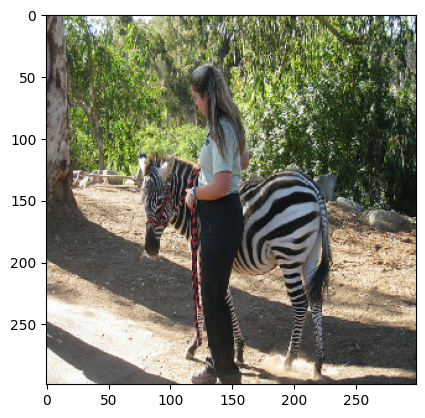

Predicted Caption:  a man is standing on a tennis court holding a racquet


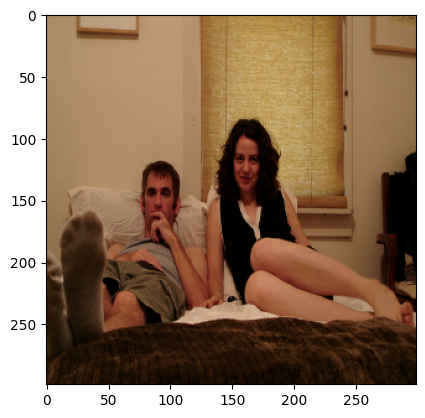

Predicted Caption:  a man is standing in a room with a wii remote


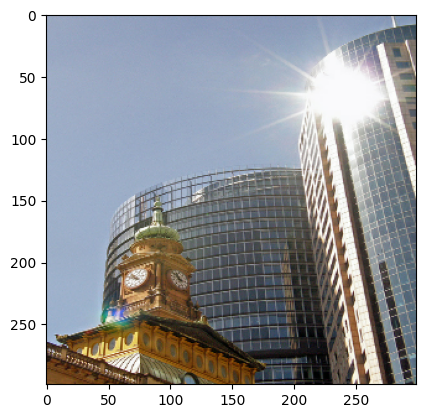

Predicted Caption:  a group of people standing on a beach with a kite


In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

## End Notes

We saw that the model starts to generate reasonable captions after a few epochs. To keep
this example easily runnable, we have trained it with a few constraints, like a minimal
number of attention heads. To improve the predictions, you can try changing these training
settings and find a good model for your use case.